# Sentiment Analysis of Airline Tweets

Twitter is an ongoing source of customer satisfaction information. Gone are the days of expensive focus groups when so many customers are putting their unfiltered thoughts about a brand on the internet. Advances in Natural Language Processing allow this data to be collected and analyzed to provide insights for brands about how they are being perceived vs their competitors.

The goal of this project is to develop a model that will classify tweets as positive, negative, or neutral for continual monitoring of customer satisfaction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from imblearn.over_sampling import SMOTE, KMeansSMOTE, SVMSMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from functions import all_models as m
from functions import plot_importances
from functions import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/Tweets.csv')

In [3]:
df.drop(inplace = True, columns=['tweet_coord', 'tweet_location', 'user_timezone', 'tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   name               14640 non-null  object
 3   retweet_count      14640 non-null  int64 
 4   text               14640 non-null  object
 5   tweet_created      14640 non-null  object
dtypes: int64(1), object(5)
memory usage: 686.4+ KB


## Processing Tweets

Before they can be passed through the model, our tweets must be preprocessed for more effective modelling. Data will then be split into training and testing sets.

In [5]:
stop_words = stopwords.words('english')
#add custom stop words
stop_words.append('http')
stop_words.append('hr')
stop_words.append('co')
stop_words.append('see')
stop_words.append('min')

def process(tweet):
    
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    
    tweet = tweet.lower() #convert to lowercase
    tweet = re.sub(r'@\w+', '', tweet) #use regex to remove mentions
    tweet = tokenizer.tokenize(tweet) #tokenize
    tweet = [word for word in tweet if word not in stop_words] #remove stopwords
    tweet = [lemmatizer.lemmatize(word) for word in tweet] #lemmatize
    tweet = ' '.join(tweet) #convert list of words back to a string
    return tweet

In [6]:
x = df['text'].apply(process)
y = df['airline_sentiment']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [8]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+')
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

## Initial Modelling

We will begin by running multiple types of models with base parameters to see which run best with our dataset. 

In [9]:
objects = [LogisticRegression(fit_intercept=False, C=1e12, solver='saga'), 
           Pipeline([('ss', StandardScaler(with_mean=False)), ('knn', KNeighborsClassifier())]),
           Pipeline([('bz', Binarizer()), ('bayes', MultinomialNB())]),
           Pipeline([('ss', StandardScaler(with_mean=False)), ('svm', SVC())]),
           DecisionTreeClassifier(), 
           RandomForestClassifier(), 
           GradientBoostingClassifier(),
           AdaBoostClassifier(),
           XGBClassifier(),
           CatBoostClassifier(verbose=False)]
index = ['Logistic Regression', 'Nearest Neighbors', 'Naive Bayes', 'SVM', 
         'Decision Tree', 'Random Forest', 'Gradient Boost', 'AdaBoost', 'XGBoost', 'CatBoost']

Logistic Regression Results:


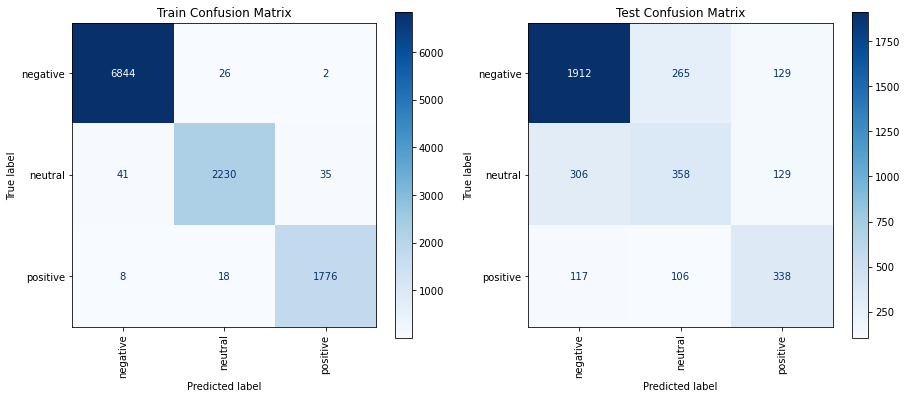

              precision    recall  f1-score   support

    negative       0.82      0.83      0.82      2306
     neutral       0.49      0.45      0.47       793
    positive       0.57      0.60      0.58       561

    accuracy                           0.71      3660
   macro avg       0.63      0.63      0.63      3660
weighted avg       0.71      0.71      0.71      3660



Nearest Neighbors Results:


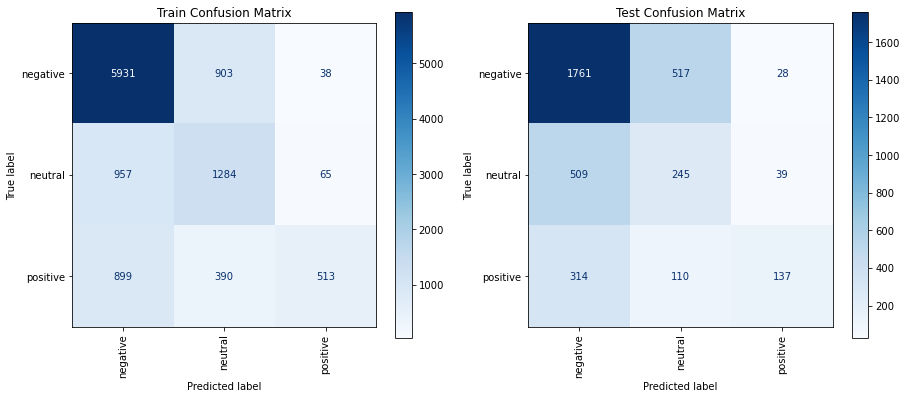

              precision    recall  f1-score   support

    negative       0.68      0.76      0.72      2306
     neutral       0.28      0.31      0.29       793
    positive       0.67      0.24      0.36       561

    accuracy                           0.59      3660
   macro avg       0.54      0.44      0.46      3660
weighted avg       0.59      0.59      0.57      3660



Naive Bayes Results:


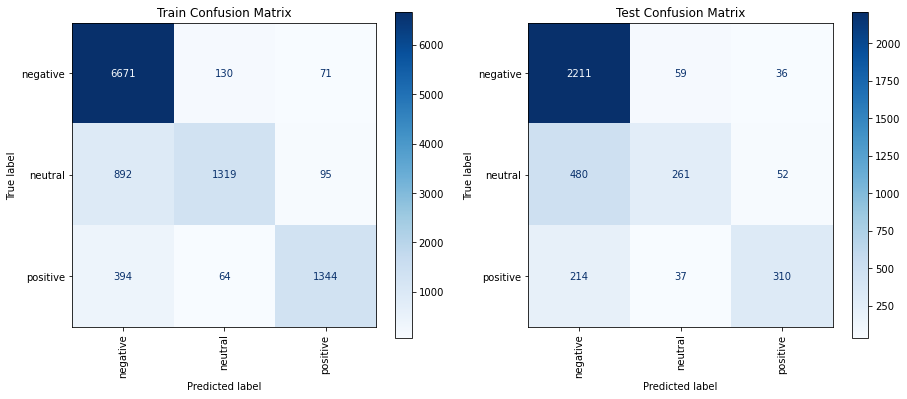

              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      2306
     neutral       0.73      0.33      0.45       793
    positive       0.78      0.55      0.65       561

    accuracy                           0.76      3660
   macro avg       0.76      0.61      0.65      3660
weighted avg       0.76      0.76      0.73      3660



SVM Results:


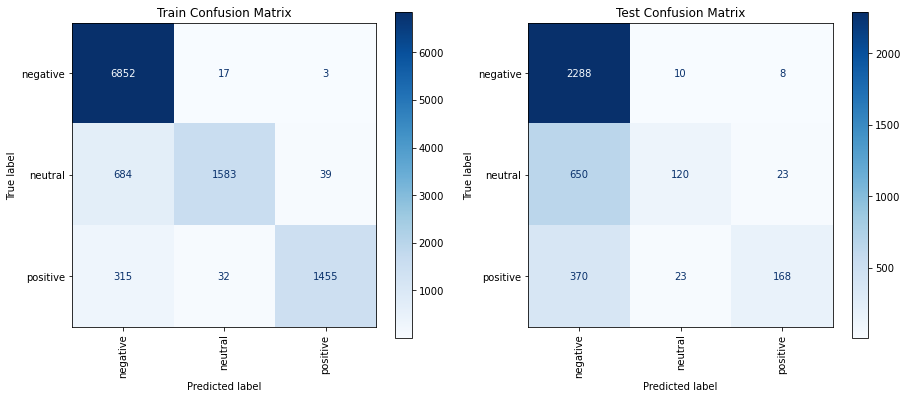

              precision    recall  f1-score   support

    negative       0.69      0.99      0.82      2306
     neutral       0.78      0.15      0.25       793
    positive       0.84      0.30      0.44       561

    accuracy                           0.70      3660
   macro avg       0.77      0.48      0.50      3660
weighted avg       0.74      0.70      0.64      3660



Decision Tree Results:


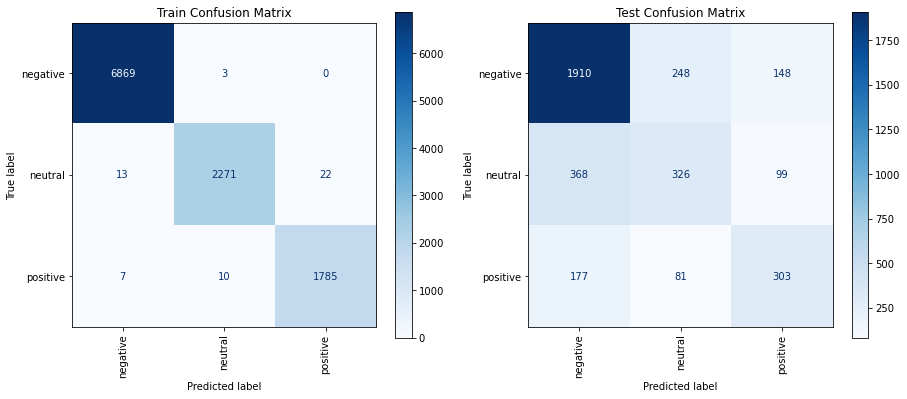

              precision    recall  f1-score   support

    negative       0.78      0.83      0.80      2306
     neutral       0.50      0.41      0.45       793
    positive       0.55      0.54      0.55       561

    accuracy                           0.69      3660
   macro avg       0.61      0.59      0.60      3660
weighted avg       0.68      0.69      0.69      3660



Random Forest Results:


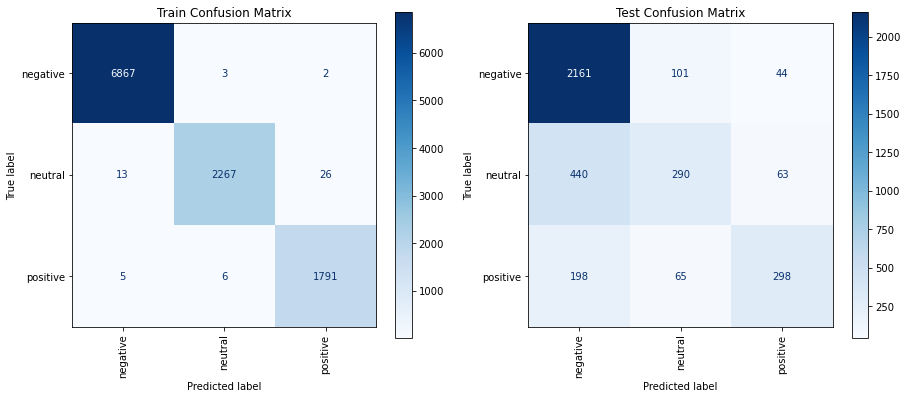

              precision    recall  f1-score   support

    negative       0.77      0.94      0.85      2306
     neutral       0.64      0.37      0.46       793
    positive       0.74      0.53      0.62       561

    accuracy                           0.75      3660
   macro avg       0.71      0.61      0.64      3660
weighted avg       0.74      0.75      0.73      3660



Gradient Boost Results:


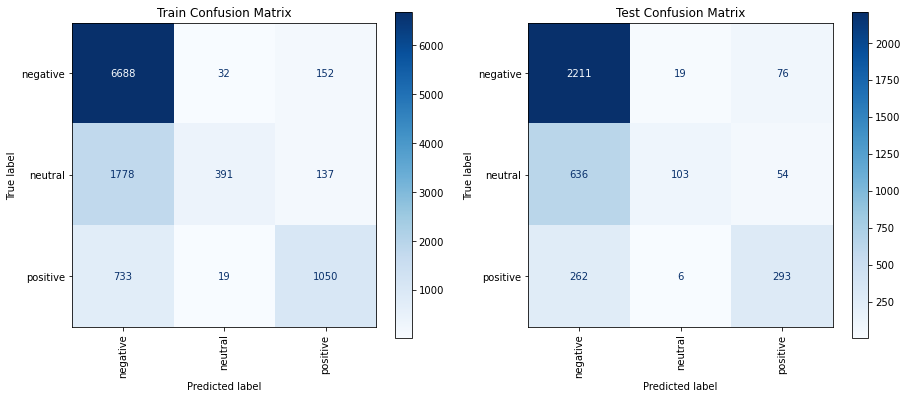

              precision    recall  f1-score   support

    negative       0.71      0.96      0.82      2306
     neutral       0.80      0.13      0.22       793
    positive       0.69      0.52      0.60       561

    accuracy                           0.71      3660
   macro avg       0.74      0.54      0.55      3660
weighted avg       0.73      0.71      0.65      3660



AdaBoost Results:


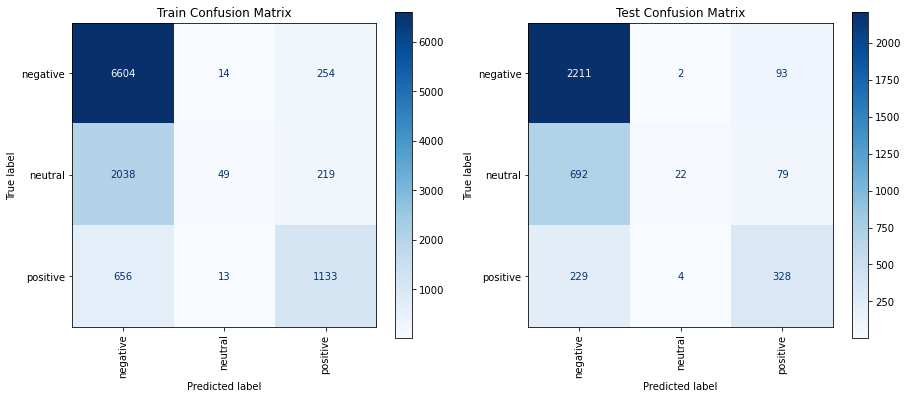

              precision    recall  f1-score   support

    negative       0.71      0.96      0.81      2306
     neutral       0.79      0.03      0.05       793
    positive       0.66      0.58      0.62       561

    accuracy                           0.70      3660
   macro avg       0.72      0.52      0.50      3660
weighted avg       0.72      0.70      0.62      3660



XGBoost Results:
[11:27:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


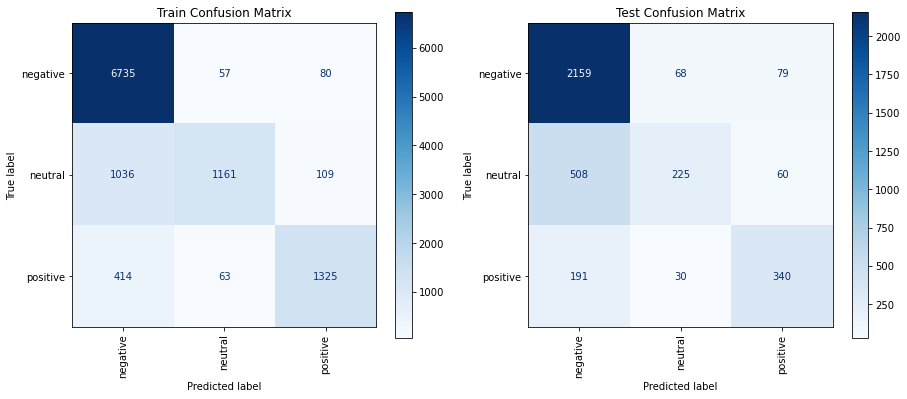

              precision    recall  f1-score   support

    negative       0.76      0.94      0.84      2306
     neutral       0.70      0.28      0.40       793
    positive       0.71      0.61      0.65       561

    accuracy                           0.74      3660
   macro avg       0.72      0.61      0.63      3660
weighted avg       0.74      0.74      0.71      3660



CatBoost Results:


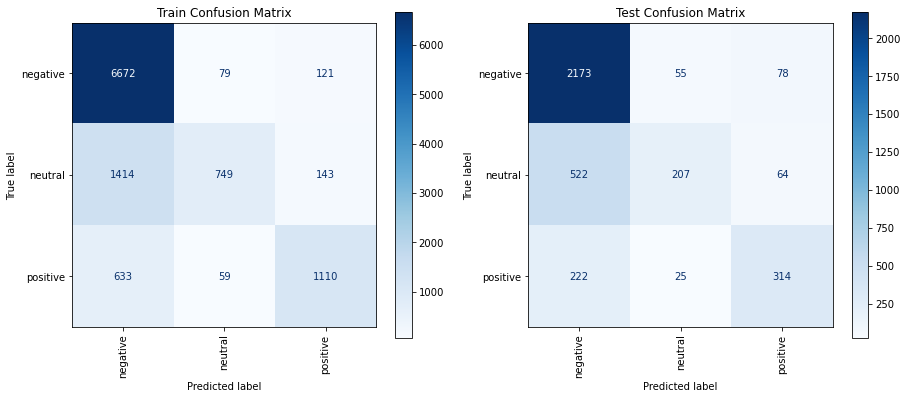

              precision    recall  f1-score   support

    negative       0.74      0.94      0.83      2306
     neutral       0.72      0.26      0.38       793
    positive       0.69      0.56      0.62       561

    accuracy                           0.74      3660
   macro avg       0.72      0.59      0.61      3660
weighted avg       0.73      0.74      0.70      3660





,Precision Score,Recall Score,Accuracy Score,F1 Score
Logistic Regression,62.57%,62.77%,71.26%,62.62%
Nearest Neighbors,54.47%,43.89%,58.55%,45.76%
Naive Bayes,75.70%,61.35%,76.01%,64.97%
SVM,77.34%,48.10%,70.38%,50.36%
Decision Tree,60.89%,59.32%,69.37%,59.94%
Random Forest,71.46%,61.13%,75.11%,64.27%
Gradient Boost,73.62%,53.70%,71.23%,54.53%
AdaBoost,71.59%,52.37%,69.97%,49.50%
XGBoost,72.06%,60.87%,74.43%,63.11%
CatBoost,71.83%,58.77%,73.61%,61.10%


The model with the highest precision score is SVM.
The model with the highest recall score is Logistic Regression.
The model with the highest accuracy score is Naive Bayes.
The model with the highest F1 score is Naive Bayes.


In [10]:
models = m(x_train, x_test, y_train, y_test, objects=objects, index=index)

Most of our models display quite a bit of overfitting, which is unsurprising given the class imbalances present in the data. Before tuning a model, we will try a few strategies to combat this.

In [11]:
#Demonstrate class imbalance
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Removing Class Imbalance with SMOTE

I will test three different SMOTE techniques: vanilla SMOTE, KMeansSMOTE, and SVMSMOTE. For efficiency I will test all three on an XGBoost algorithm only, and then run all my models with the best performing method.

[11:32:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


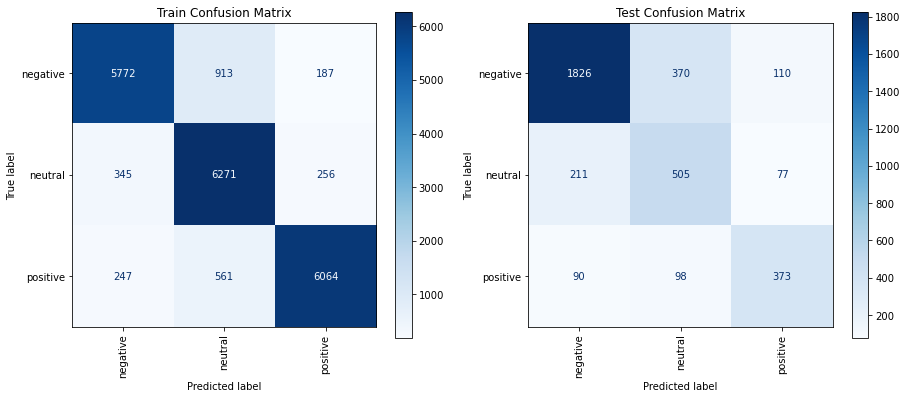

              precision    recall  f1-score   support

    negative       0.86      0.79      0.82      2306
     neutral       0.52      0.64      0.57       793
    positive       0.67      0.66      0.67       561

    accuracy                           0.74      3660
   macro avg       0.68      0.70      0.69      3660
weighted avg       0.76      0.74      0.74      3660





In [12]:
smote = SMOTE()
model_1 = XGBClassifier()

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

model_1.fit(x_train_smote, y_train_smote)

metrics(model_1, x_train_smote, y_train_smote, x_test, y_test)

[11:32:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


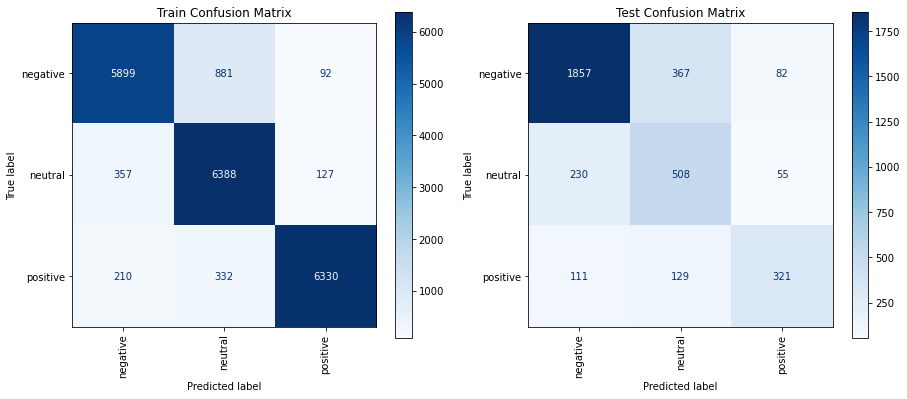

              precision    recall  f1-score   support

    negative       0.84      0.81      0.82      2306
     neutral       0.51      0.64      0.57       793
    positive       0.70      0.57      0.63       561

    accuracy                           0.73      3660
   macro avg       0.68      0.67      0.67      3660
weighted avg       0.75      0.73      0.74      3660





In [13]:
kmeans_smote = KMeansSMOTE()
model_2 = XGBClassifier()

x_train_ksmote, y_train_ksmote = kmeans_smote.fit_resample(x_train, y_train)

model_2.fit(x_train_ksmote, y_train_ksmote)

metrics(model_2, x_train_ksmote, y_train_ksmote, x_test, y_test)

[11:33:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


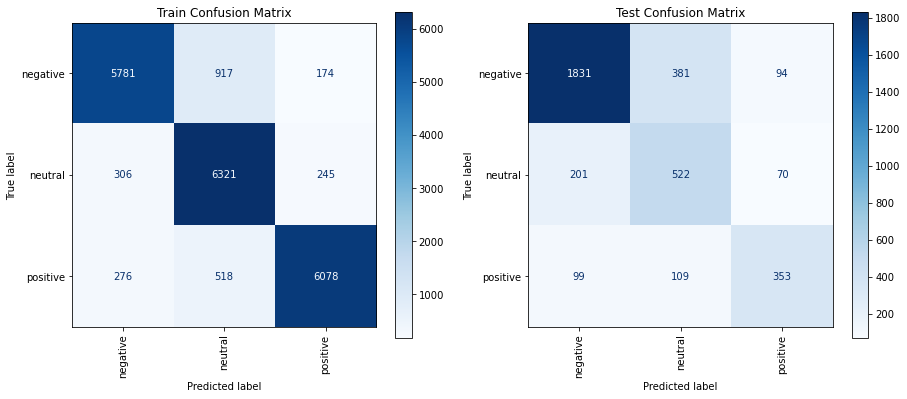

              precision    recall  f1-score   support

    negative       0.86      0.79      0.83      2306
     neutral       0.52      0.66      0.58       793
    positive       0.68      0.63      0.65       561

    accuracy                           0.74      3660
   macro avg       0.69      0.69      0.69      3660
weighted avg       0.76      0.74      0.75      3660





In [14]:
svmsmote = SVMSMOTE()
model_3 = XGBClassifier()

x_train_svmsmote, y_train_svmsmote = svmsmote.fit_resample(x_train, y_train)

model_3.fit(x_train_svmsmote, y_train_svmsmote)

metrics(model_3, x_train_svmsmote, y_train_svmsmote, x_test, y_test)

SVM SMOTE is the highest performing of the three, so I will use this algorithm wth all the models to ensure I select the best performing model.

Logistic Regression Results:


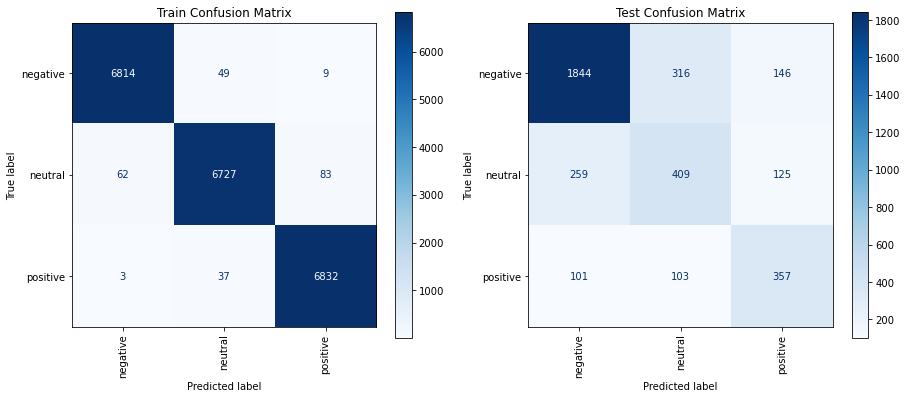

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      2306
     neutral       0.49      0.52      0.50       793
    positive       0.57      0.64      0.60       561

    accuracy                           0.71      3660
   macro avg       0.63      0.65      0.64      3660
weighted avg       0.72      0.71      0.72      3660



Nearest Neighbors Results:


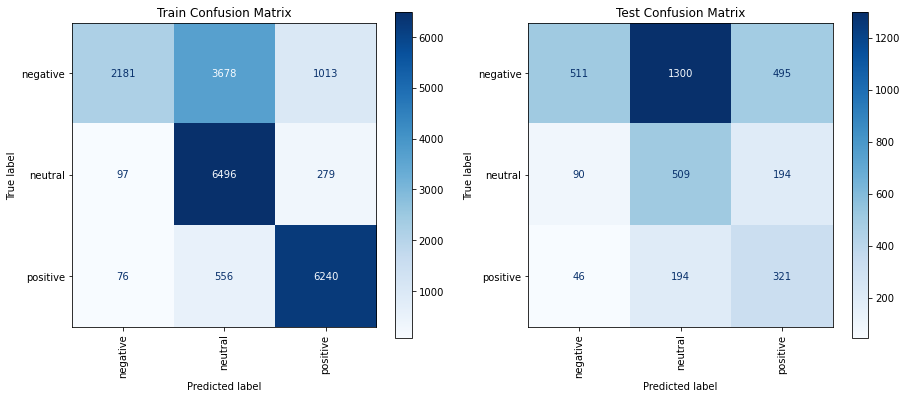

              precision    recall  f1-score   support

    negative       0.79      0.22      0.35      2306
     neutral       0.25      0.64      0.36       793
    positive       0.32      0.57      0.41       561

    accuracy                           0.37      3660
   macro avg       0.45      0.48      0.37      3660
weighted avg       0.60      0.37      0.36      3660



Naive Bayes Results:


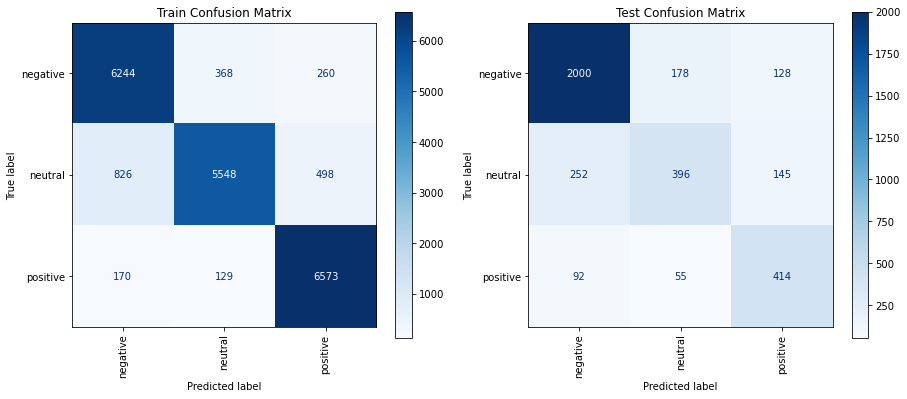

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      2306
     neutral       0.63      0.50      0.56       793
    positive       0.60      0.74      0.66       561

    accuracy                           0.77      3660
   macro avg       0.70      0.70      0.69      3660
weighted avg       0.77      0.77      0.76      3660



SVM Results:


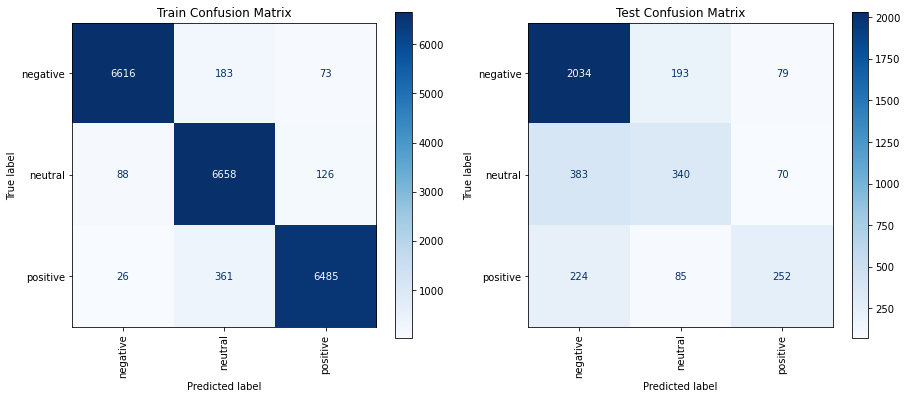

              precision    recall  f1-score   support

    negative       0.77      0.88      0.82      2306
     neutral       0.55      0.43      0.48       793
    positive       0.63      0.45      0.52       561

    accuracy                           0.72      3660
   macro avg       0.65      0.59      0.61      3660
weighted avg       0.70      0.72      0.70      3660



Decision Tree Results:


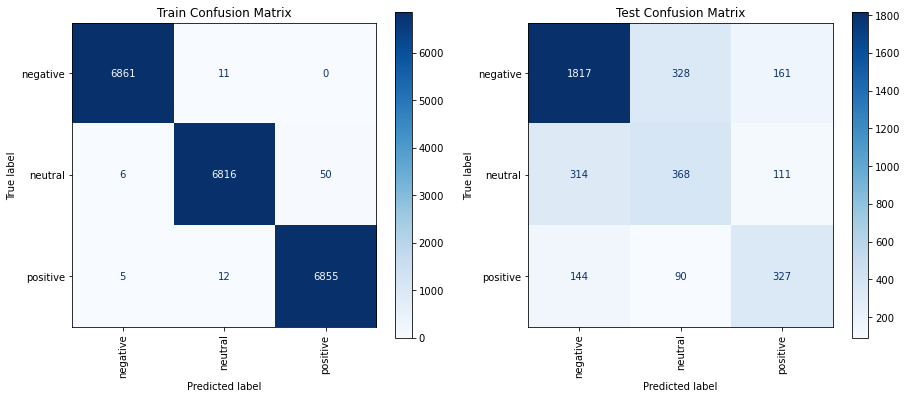

              precision    recall  f1-score   support

    negative       0.80      0.79      0.79      2306
     neutral       0.47      0.46      0.47       793
    positive       0.55      0.58      0.56       561

    accuracy                           0.69      3660
   macro avg       0.60      0.61      0.61      3660
weighted avg       0.69      0.69      0.69      3660



Random Forest Results:


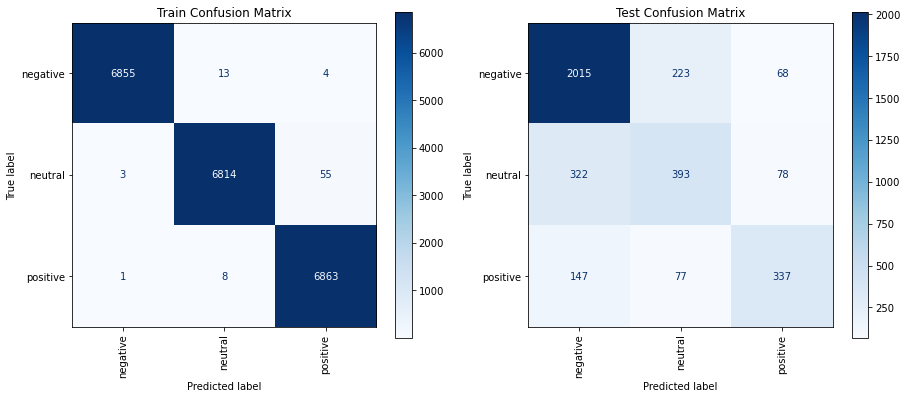

              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      2306
     neutral       0.57      0.50      0.53       793
    positive       0.70      0.60      0.65       561

    accuracy                           0.75      3660
   macro avg       0.69      0.66      0.67      3660
weighted avg       0.74      0.75      0.74      3660



Gradient Boost Results:


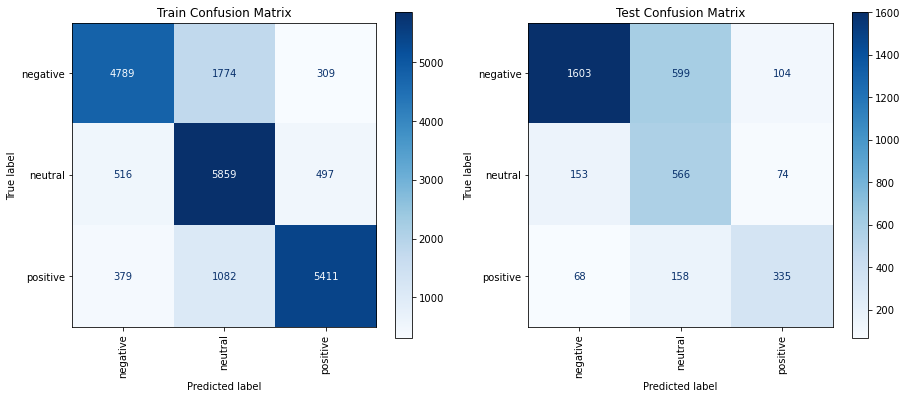

              precision    recall  f1-score   support

    negative       0.88      0.70      0.78      2306
     neutral       0.43      0.71      0.53       793
    positive       0.65      0.60      0.62       561

    accuracy                           0.68      3660
   macro avg       0.65      0.67      0.65      3660
weighted avg       0.75      0.68      0.70      3660



AdaBoost Results:


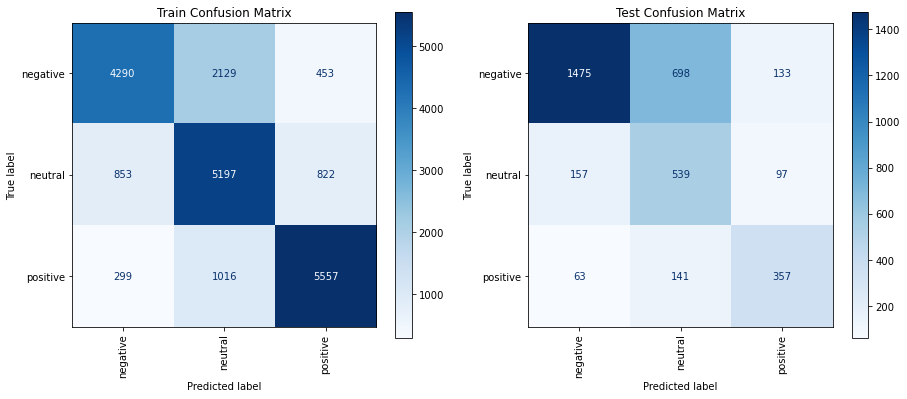

              precision    recall  f1-score   support

    negative       0.87      0.64      0.74      2306
     neutral       0.39      0.68      0.50       793
    positive       0.61      0.64      0.62       561

    accuracy                           0.65      3660
   macro avg       0.62      0.65      0.62      3660
weighted avg       0.73      0.65      0.67      3660



XGBoost Results:
[11:41:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


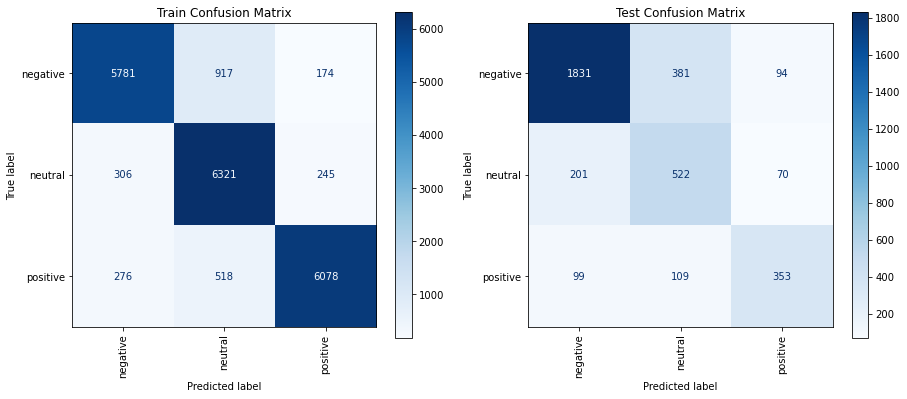

              precision    recall  f1-score   support

    negative       0.86      0.79      0.83      2306
     neutral       0.52      0.66      0.58       793
    positive       0.68      0.63      0.65       561

    accuracy                           0.74      3660
   macro avg       0.69      0.69      0.69      3660
weighted avg       0.76      0.74      0.75      3660



CatBoost Results:


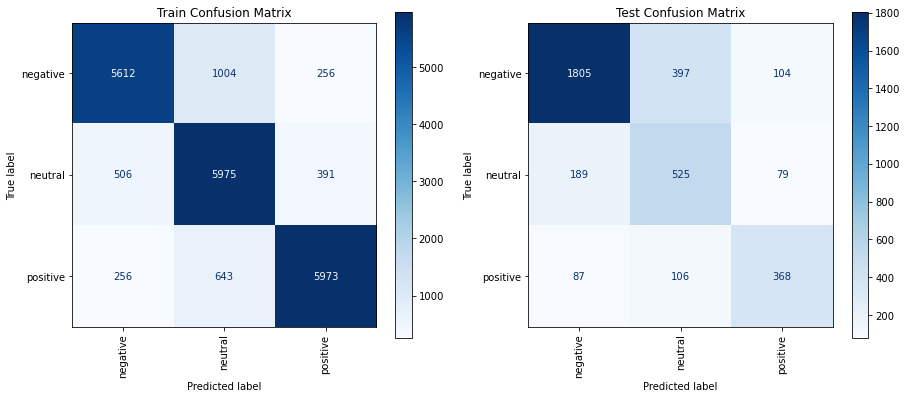

              precision    recall  f1-score   support

    negative       0.87      0.78      0.82      2306
     neutral       0.51      0.66      0.58       793
    positive       0.67      0.66      0.66       561

    accuracy                           0.74      3660
   macro avg       0.68      0.70      0.69      3660
weighted avg       0.76      0.74      0.74      3660





,Precision Score,Recall Score,Accuracy Score,F1 Score
Logistic Regression,63.30%,65.06%,71.31%,64.10%
Nearest Neighbors,45.39%,47.86%,36.64%,37.29%
Naive Bayes,69.51%,70.15%,76.78%,69.35%
SVM,64.96%,58.67%,71.75%,60.94%
Decision Tree,60.43%,61.16%,68.63%,60.77%
Random Forest,69.20%,65.67%,75.00%,67.20%
Gradient Boost,65.32%,66.87%,68.42%,64.50%
AdaBoost,62.32%,65.19%,64.78%,61.86%
XGBoost,68.59%,69.38%,73.93%,68.62%
CatBoost,68.20%,70.03%,73.72%,68.71%


The model with the highest precision score is Naive Bayes.
The model with the highest recall score is Naive Bayes.
The model with the highest accuracy score is Naive Bayes.
The model with the highest F1 score is Naive Bayes.


In [15]:
models_smote = m(x_train_svmsmote, x_test, y_train_svmsmote, y_test, objects=objects, index=index)

Viewing the feature importances for some of our tree-based models can help identify key words that classify the sentiment of a tweet.

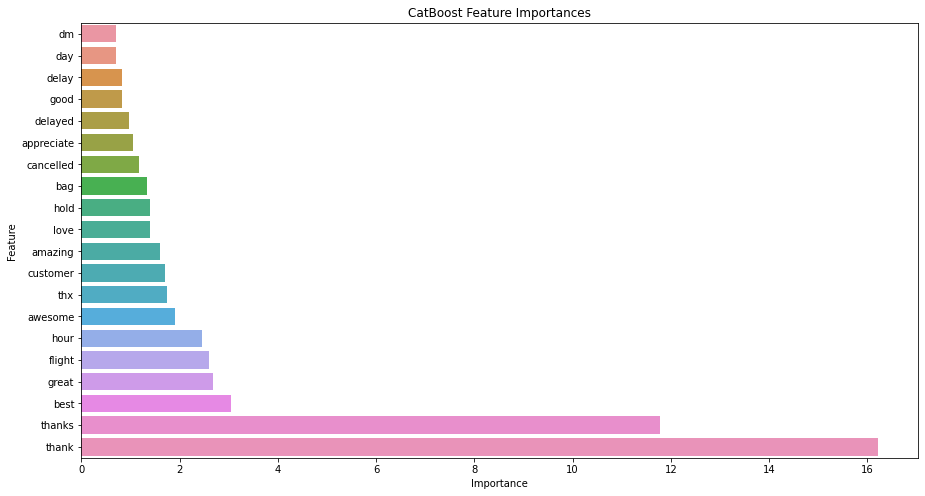

In [16]:
importances = sorted(list(zip(models_smote[9].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title(f'{index[9]} Feature Importances')
plt.show();

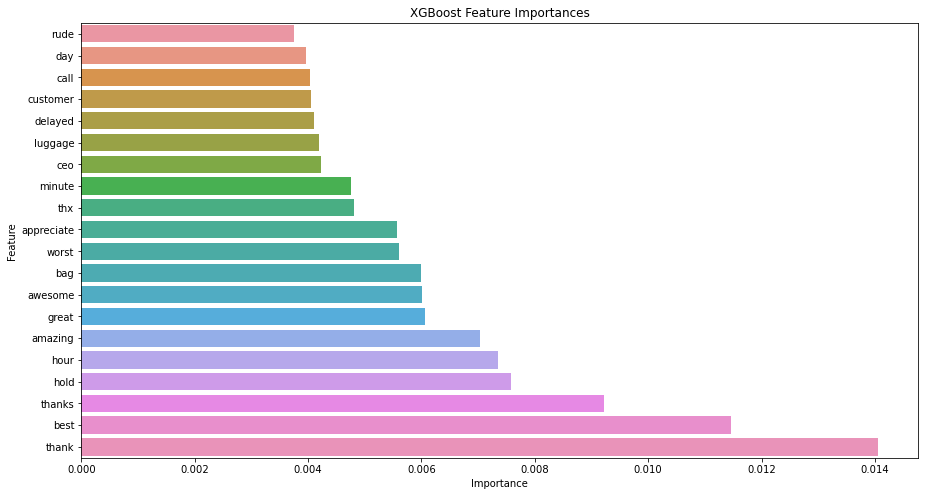

In [17]:
importances = sorted(list(zip(models_smote[8].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title(f'{index[8]} Feature Importances')
plt.show();

## Parameter Tuning

Multinomial Naive Bayes, XGBoost, and CatBoost are the three highest performing algorithms, so we will tune parameters for each of these algorithms to improve performance.

### Multinomial Naive Bayes

Optimal Parameters: {'bayes__alpha': 0.01}


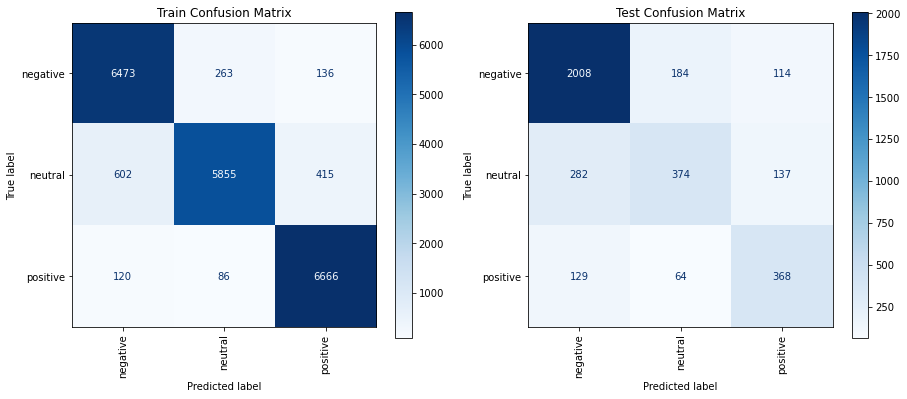

              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      2306
     neutral       0.60      0.47      0.53       793
    positive       0.59      0.66      0.62       561

    accuracy                           0.75      3660
   macro avg       0.68      0.67      0.67      3660
weighted avg       0.74      0.75      0.75      3660



In [18]:
mnb = Pipeline([('bz', Binarizer()), ('bayes', MultinomialNB())])
mnb_params = {'bayes__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

#mnb.get_params().keys()

mnb_gridsearch = GridSearchCV(estimator=mnb, param_grid=mnb_params, cv=5)
mnb_gridsearch.fit(x_train_svmsmote, y_train_svmsmote)

print(f"Optimal Parameters: {mnb_gridsearch.best_params_}")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_confusion_matrix(mnb_gridsearch.best_estimator_, x_train_svmsmote, y_train_svmsmote, ax=ax[0], cmap=plt.cm.Blues, xticks_rotation='vertical')
ax[0].set_title('Train Confusion Matrix')
plot_confusion_matrix(mnb_gridsearch.best_estimator_, x_test, y_test, ax=ax[1], cmap=plt.cm.Blues, xticks_rotation='vertical')
ax[1].set_title('Test Confusion Matrix')
plt.show()
print(classification_report(y_test, mnb_gridsearch.best_estimator_.predict(x_test)))

### XGBoost

Optimal Parameters: {'gamma': 0, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 100, 'subsample': 0.75}


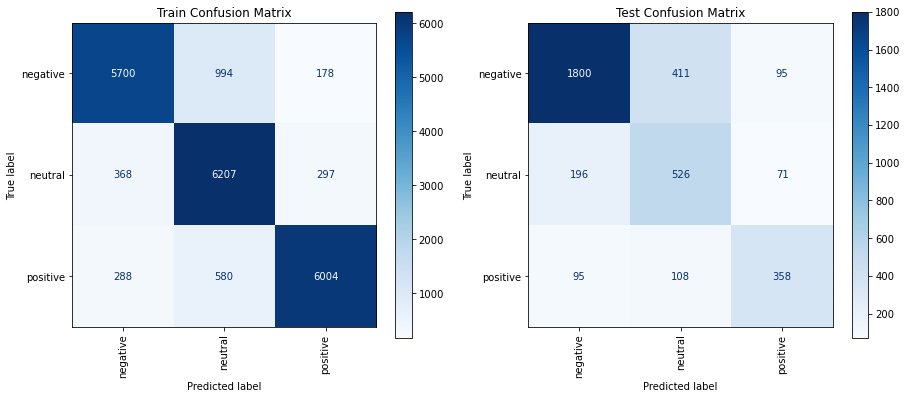

              precision    recall  f1-score   support

    negative       0.86      0.78      0.82      2306
     neutral       0.50      0.66      0.57       793
    positive       0.68      0.64      0.66       561

    accuracy                           0.73      3660
   macro avg       0.68      0.69      0.68      3660
weighted avg       0.76      0.73      0.74      3660



In [19]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 4, 5],
    'gamma': [0, 1, 5],
    'min_child_weight': [0, 1, 2],
    'subsample': [0.5, 0.75, 1.0]
}


xgb_gridsearch = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5)
xgb_gridsearch.fit(x_train_svmsmote, y_train_svmsmote)

print(f"Optimal Parameters: {xgb_gridsearch.best_params_}")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_confusion_matrix(xgb_gridsearch.best_estimator_, x_train_svmsmote, y_train_svmsmote, ax=ax[0], cmap=plt.cm.Blues, xticks_rotation='vertical')
ax[0].set_title('Train Confusion Matrix')
plot_confusion_matrix(xgb_gridsearch.best_estimator_, x_test, y_test, ax=ax[1], cmap=plt.cm.Blues, xticks_rotation='vertical')
ax[1].set_title('Test Confusion Matrix')
plt.show()
print(classification_report(y_test, xgb_gridsearch.best_estimator_.predict(x_test)))

Write some analysis

## Productionalizing the Model

In order to put this model into production, we will need to build a function that collects tweets, processes them, and categorizes them.

In [25]:
def predict_sentiment(tweet):
    tweet = process(tweet)
    tweet = [tweet]
    tweet = vectorizer.transform(tweet)
    print(xgb_gridsearch.best_estimator_.predict(tweet))

In [26]:
test_tweet ='@united They had 1 job...1 job only.. to get my bags from EWR to Akron OHIO... and here we are 1 hour later a cracked luggage that went to war without warning'
#test tweet link: https://twitter.com/Mc_Lolahstic/status/1437106441165418502?s=20


predict_sentiment(test_tweet)

['negative']
